In [1]:
# Load data manipulation package
import numpy as np
import pandas as pd

# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# Load statistics package
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
# Import dataset from csv file
data = pd.read_csv('diabetes_prediction_dataset.csv')

# Table check
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
# Rename columns

data.rename(columns = {'smoking_history' : 'smoking',
                       'HbA1c_level' : 'HbA1c',
                       'blood_glucose_level' : 'glucose'},
            inplace = True)

### Check for missing value

In [4]:
# Check for missing values

data.isna().sum()

gender           0
age              0
hypertension     0
heart_disease    0
smoking          0
bmi              0
HbA1c            0
glucose          0
diabetes         0
dtype: int64

### Check for duplicates

In [5]:
# Duplicates check

data[data.duplicated(keep = False)]

,gender,age,hypertension,heart_disease,smoking,bmi,HbA1c,glucose,diabetes
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
10,Female,53.0,0,0,never,27.32,6.1,85,0
14,Female,76.0,0,0,No Info,27.32,5.0,160,0
18,Female,42.0,0,0,No Info,27.32,5.7,80,0
41,Male,5.0,0,0,No Info,27.32,6.6,130,0
...,...,...,...,...,...,...,...,...,...
99980,Female,52.0,0,0,never,27.32,6.1,145,0
99985,Male,25.0,0,0,No Info,27.32,5.8,145,0
99989,Female,26.0,0,0,No Info,27.32,5.0,158,0
99990,Male,39.0,0,0,No Info,27.32,6.1,100,0


In [6]:
# Duplicates check

data.duplicated().sum()

3854

In [7]:
# Drop duplicates
data.drop_duplicates(keep = 'first', inplace = True)

# Re-check duplicates
data.duplicated().sum()

0

### Check for outliers

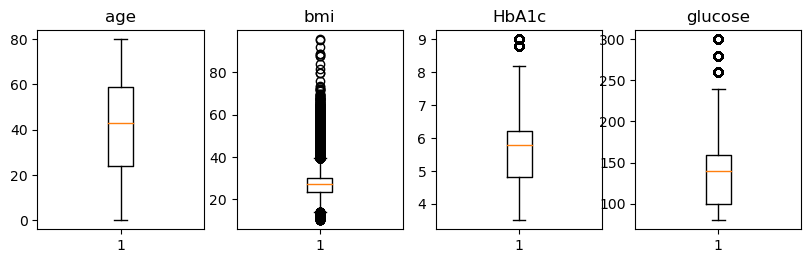

In [8]:
# Check for outliers
columns = ['age', 'bmi','HbA1c','glucose']

plt.subplots(figsize=(15,15))
for idx, name in enumerate(columns):
    plt.subplot(5, 6, idx + 1)
    plt.boxplot(data[name])
    plt.title(name)

In [9]:
# Drop outliers
selectedFeatures = ['bmi','HbA1c','glucose']

for index, names in enumerate(selectedFeatures):
    q1 = data[names].quantile(0.25)
    q3 = data[names].quantile(0.75)
    iqr = q3 - q1
    lowerbound = q1 - 1.5*iqr
    upperbound = q3 + 1.5*iqr
    outliers = data[(data[names] < lowerbound) | (data[names] > upperbound)]
    data = data.drop(outliers.index)

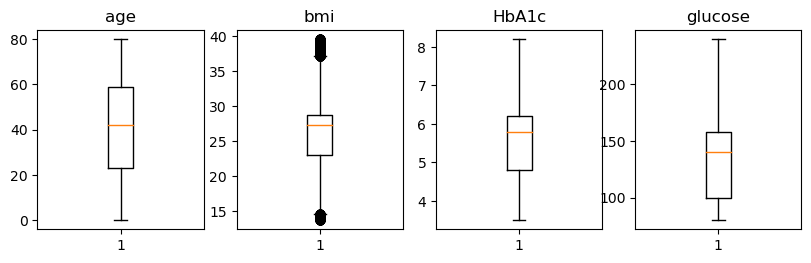

In [10]:
# Re-check outliers
columns = ['age', 'bmi','HbA1c','glucose']

plt.subplots(figsize=(15,15))
for idx, name in enumerate(columns):
    plt.subplot(5, 6, idx + 1)
    plt.boxplot(data[name])
    plt.title(name)

In [11]:
# Check data shape

data.shape

(88195, 9)

In [12]:
# Data info

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88195 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         88195 non-null  object 
 1   age            88195 non-null  float64
 2   hypertension   88195 non-null  int64  
 3   heart_disease  88195 non-null  int64  
 4   smoking        88195 non-null  object 
 5   bmi            88195 non-null  float64
 6   HbA1c          88195 non-null  float64
 7   glucose        88195 non-null  int64  
 8   diabetes       88195 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.7+ MB


The dataset contains binary response variable:
- `diabetes` : binary classification
    - 0 : indicating the absence of diabetes
    - 1 : indicating the presence of diabetes

The potential predictors are:
1. `gender` : biological sex of the individual (multicategory)
2. `age` : age of the individual (continuous)
3. `hypertension` : indicates of hypertension (binary)
4. `heart_disease` : indicates of heart disease (binary)
5. `smoking` : smoking status (multicategory)
6. `bmi` : body mass index (continuous)
7. `HbA1c` : hemoglobin level (continuous)
8. `glucose` : glucose level (continuous)

## 2. Sample Splitting

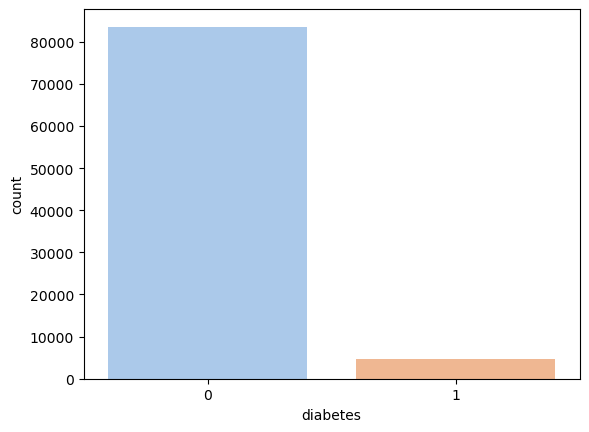

In [13]:
# Response variable distribution plot

sns.countplot('diabetes', data = data, palette = 'pastel')
plt.show()

In [14]:
# Check the proportion of response variable

data['diabetes'].value_counts(normalize = True)

0    0.947639
1    0.052361
Name: diabetes, dtype: float64

The proportion of the response variable is imbalanced.

To get the same ratio in training & testing set, define a stratified splitting based on the response variable.

In [15]:
# Define the response variable
response_variable = 'diabetes'

# Split response and predictors
y = data[response_variable]
X = data.drop(columns = [response_variable], axis = 1)

# Validate the splitting
print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (88195,)
X shape : (88195, 8)


Next, split the training and testing set from each predictors (X) and response (y).
- Set `stratify = y` for splitting the sample with stratify, based on the proportion of response y.
- Set `test_size = 0.3` for holding 30% of the sample as a testing set.
- Set `random_state = 73` for reproducibility.

In [16]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 73)

# Validate splitting
print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (61736, 8)
y train shape : (61736,)
X test shape  : (26459, 8)
y test shape  : (26459,)


Check the proportion of response y in each training and testing set.

In [17]:
y_train.value_counts(normalize = True)

0    0.947632
1    0.052368
Name: diabetes, dtype: float64

In [18]:
y_test.value_counts(normalize = True)

0    0.947655
1    0.052345
Name: diabetes, dtype: float64

## 3. Exploratory Data Analysis

- To make a model that predicts well on unseen data, we must prevent leakage of test set information.
- Thus, we only explore on **training set**.

In [19]:
# Concatenate X_train and y_train as data_train
data_train = pd.concat((X_train, y_train), axis=1)

# Validate data_train
print('Train data shape:', data_train.shape)
data_train.head()

Train data shape: (61736, 9)


,gender,age,hypertension,heart_disease,smoking,bmi,HbA1c,glucose,diabetes
10474,Male,27.0,0,0,never,21.23,3.5,145,0
92174,Male,12.0,0,0,never,19.72,4.5,158,0
2351,Female,48.0,0,0,No Info,27.90,5.8,140,0
82543,Female,61.0,0,0,never,19.47,5.0,160,0
85789,Female,29.0,0,0,never,24.36,6.2,145,0


### Describe data

In [20]:
# Describe data

data_train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,61736,3,Female,35826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,61736.0,NaN,NaN,NaN,41.085572,22.646661,0.08,23.0,42.0,59.0,80.0
hypertension,61736.0,NaN,NaN,NaN,0.068631,0.252828,0.0,0.0,0.0,0.0,1.0
heart_disease,61736.0,NaN,NaN,NaN,0.036575,0.187718,0.0,0.0,0.0,0.0,1.0
smoking,61736,6,never,21913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,61736.0,NaN,NaN,NaN,26.302128,5.210113,13.71,23.03,27.32,28.69,39.55
HbA1c,61736.0,NaN,NaN,NaN,5.457477,0.996171,3.5,4.8,5.8,6.2,8.2
glucose,61736.0,NaN,NaN,NaN,134.625,35.247991,80.0,100.0,140.0,158.0,240.0
diabetes,61736.0,NaN,NaN,NaN,0.052368,0.22277,0.0,0.0,0.0,0.0,1.0


### 3.1. Predictor 1: 'gender'

In [21]:
# Describe proportion of 'gender'

data_train['gender'].value_counts()

Female    35826
Male      25897
Other        13
Name: gender, dtype: int64

In [22]:
# Drop 'Other' from 'gender'
data_train.drop(data_train[(data_train['gender'] == 'Other')].index,
                inplace = True)

<AxesSubplot:xlabel='gender', ylabel='count'>

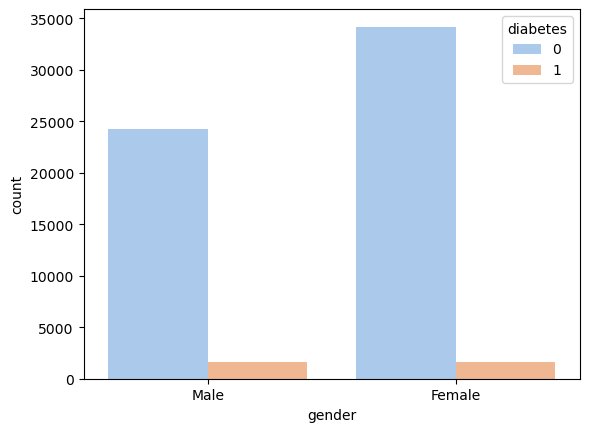

In [23]:
# Distribution plot of 'gender'
sns.countplot(data = data_train,
             x = 'gender',
             hue = 'diabetes',
             palette = 'pastel')

In [24]:
# Independence Test Function

# Import the libraries
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Create a function of independence test
def independence_test(predictor_label, alpha = 0.05):
    """
    Funtion to perform the independence test.

    Parameters
    ----------
    predictor_label : object
      The label of predictor variable.

    alpha : float in range[0,1], default = 0.05
      Probability of Type I Error (reject H0 when H0 is true).

    """
    # Build the contingency table
    crosstab = pd.crosstab(data_train[predictor_label],
                           data_train[response_variable],
                           margins = False)

    # Test whether 'Diabetes' is independent of the predictor
    stats.chi2_contingency(crosstab)

    # Result of independence test
    result = stats.chi2_contingency(crosstab)

    # Extract the test result
    stat = result[0]
    pval = result[1]

    # Print the conclusion
    if pval < alpha:
        print(f"Diabetes and {predictor_label} is not independent with P-val = {pval:.2f}.")
    else:
        print(f"Diabetes and {predictor_label} is independent with P-val = {pval:.2f}.")

In [25]:
# Perform the independence test

independence_test('gender')

Diabetes and gender is not independent with P-val = 0.00.


### 3.2. Predictor 2: 'age'

<AxesSubplot:xlabel='age', ylabel='Count'>

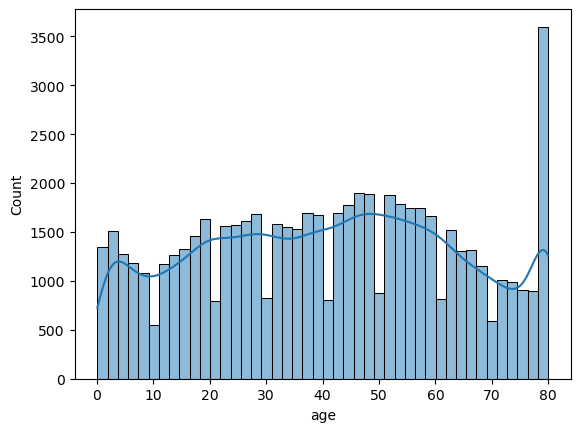

In [26]:
# Distribution plot of 'age'
sns.histplot(data = data_train,
             x = 'age',
             kde = True)

In [27]:
# Descriptive of 'age' by 'diabetes'

data_train['age'].groupby(data_train['diabetes']).describe()

,count,mean,std,min,25%,50%,75%,max
diabetes,,,,,,,,
0,58490.0,39.928635,22.437842,0.08,22.0,40.0,57.0,80.0
1,3233.0,62.079802,14.783414,3.00,54.0,64.0,74.0,80.0


<AxesSubplot:xlabel='diabetes', ylabel='age'>

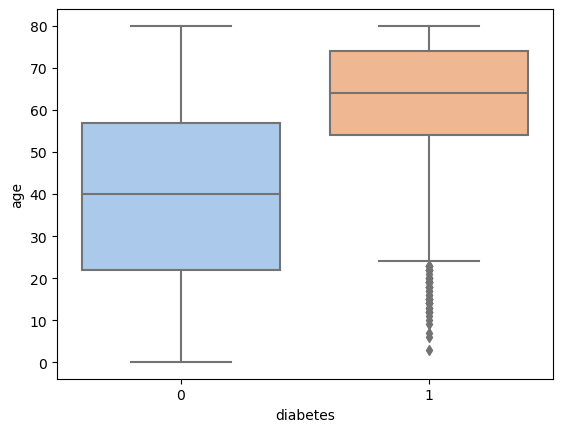

In [28]:
# Boxplot of 'age' by 'diabetes'

sns.boxplot(data_train['diabetes'], data_train['age'], palette = 'pastel')

<AxesSubplot:xlabel='age', ylabel='diabetes'>

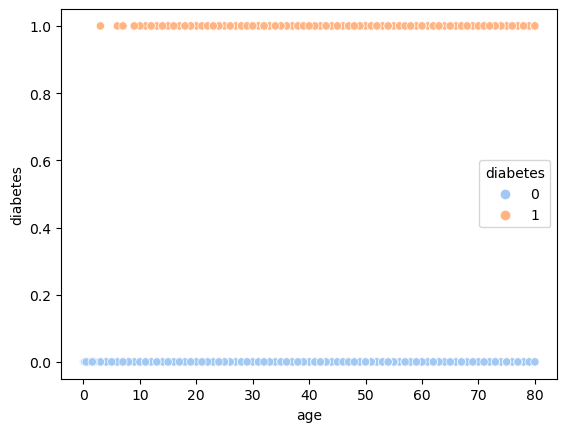

In [29]:
# Check for the perfect separation
sns.scatterplot(data = data_train,
                x = 'age',
                y = 'diabetes',
                hue = 'diabetes',
                palette = 'pastel')

### 3.3. Predictor 3: 'hypertension'

<AxesSubplot:xlabel='hypertension', ylabel='count'>

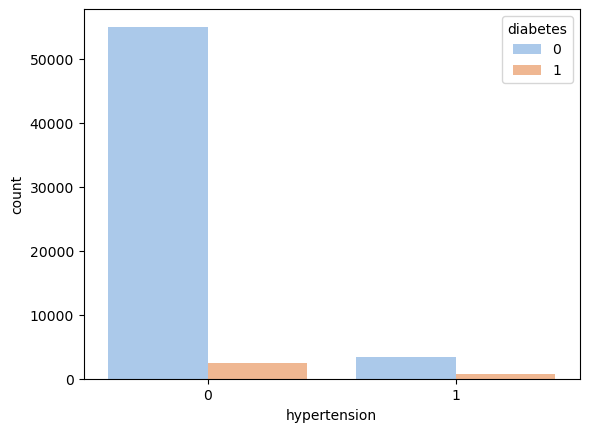

In [30]:
# Distribution plot of 'hypertension'
sns.countplot(data = data_train,
             x = 'hypertension',
             hue = 'diabetes',
             palette = 'pastel')

In [31]:
# Describe proportion of 'hypertension'

data_train['hypertension'].value_counts(normalize = True)

0    0.931355
1    0.068645
Name: hypertension, dtype: float64

In [32]:
# Perform the independence test

independence_test('hypertension')

Diabetes and hypertension is not independent with P-val = 0.00.


### 3.4. Predictor 4: 'heart_disease'

<AxesSubplot:xlabel='heart_disease', ylabel='count'>

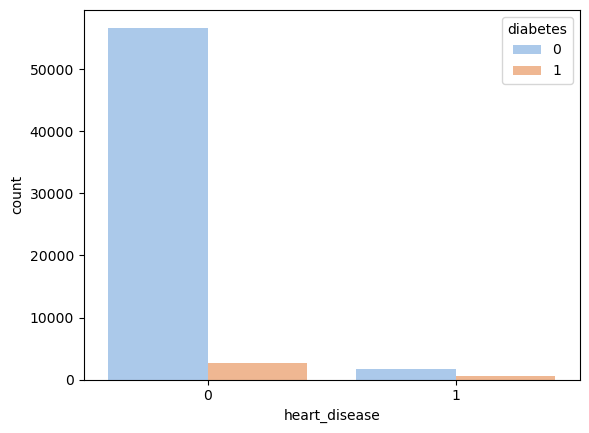

In [33]:
# Distribution plot of 'heart_disease'
sns.countplot(data = data_train,
             x = 'heart_disease',
             hue = 'diabetes',
             palette = 'pastel')

In [34]:
# Describe proportion of 'heart_disease'

data_train['heart_disease'].value_counts(normalize = True)

0    0.963417
1    0.036583
Name: heart_disease, dtype: float64

In [35]:
# Perform the independence test

independence_test('heart_disease')

Diabetes and heart_disease is not independent with P-val = 0.00.


### 3.5. Predictor 5: 'smoking'

In [36]:
# Describe proportion of 'smoking'

data_train['smoking'].value_counts(normalize = True)

never          0.354989
No Info        0.351149
current        0.095588
former         0.091911
not current    0.065438
ever           0.040925
Name: smoking, dtype: float64

<AxesSubplot:xlabel='smoking', ylabel='count'>

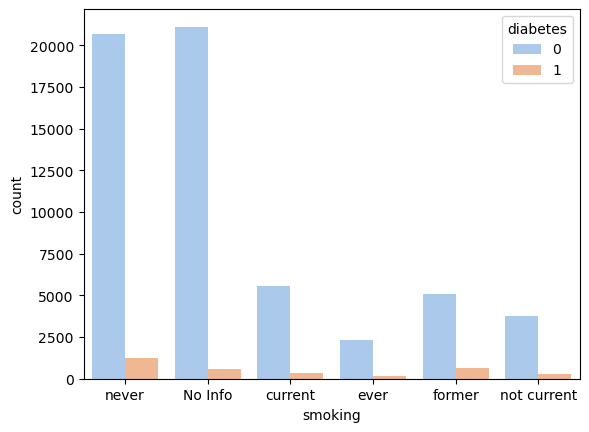

In [37]:
# Distribution plot of 'smoking'
sns.countplot(data = data_train,
             x = 'smoking',
             hue = 'diabetes',
             palette = 'pastel')

In [38]:
# Perform the independence test

independence_test('smoking')

Diabetes and smoking is not independent with P-val = 0.00.


### 3.6. Predictor 6: 'bmi'

<AxesSubplot:xlabel='bmi', ylabel='Count'>

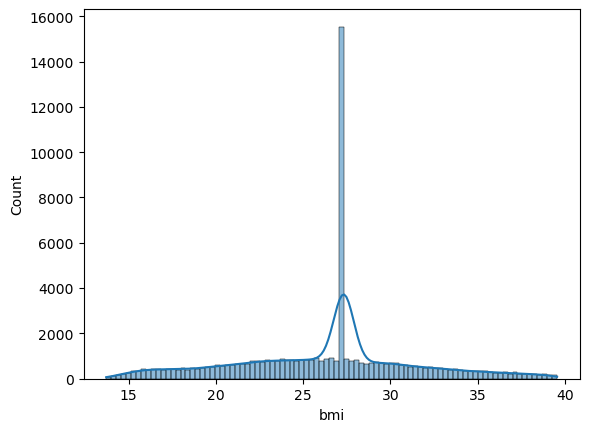

In [39]:
# Distribution plot of 'bmi'
sns.histplot(data = data_train,
             x = 'bmi',
             kde = True)

In [40]:
# Descriptive of 'bmi' by 'diabetes'

data_train['bmi'].groupby(data_train['diabetes']).describe()

,count,mean,std,min,25%,50%,75%,max
diabetes,,,,,,,,
0,58490.0,26.122602,5.185073,13.71,22.82,27.32,28.35,39.55
1,3233.0,29.548729,4.548296,13.78,27.32,28.34,32.98,39.55


<AxesSubplot:xlabel='diabetes', ylabel='bmi'>

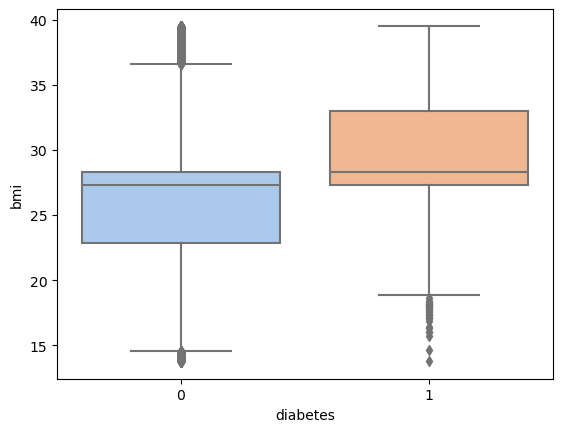

In [41]:
# Boxplot of 'bmi' by 'diabetes'

sns.boxplot(data_train['diabetes'], data_train['bmi'], palette = 'pastel')

<AxesSubplot:xlabel='bmi', ylabel='diabetes'>

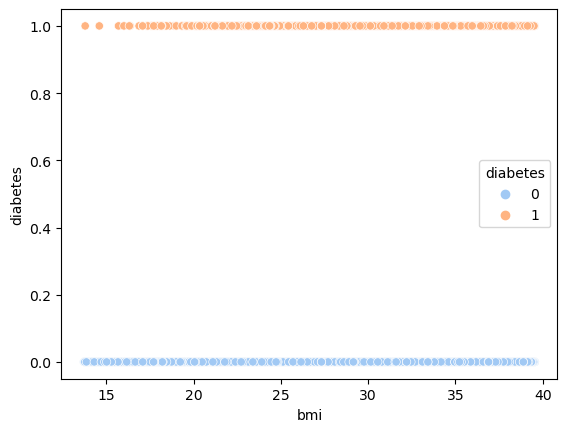

In [42]:
# Check for the perfect separation
sns.scatterplot(data = data_train,
                x = 'bmi',
                y = 'diabetes',
                hue = 'diabetes',
                palette = 'pastel')

### 3.7. Predictor 7: 'HbA1c'

<AxesSubplot:xlabel='HbA1c', ylabel='Count'>

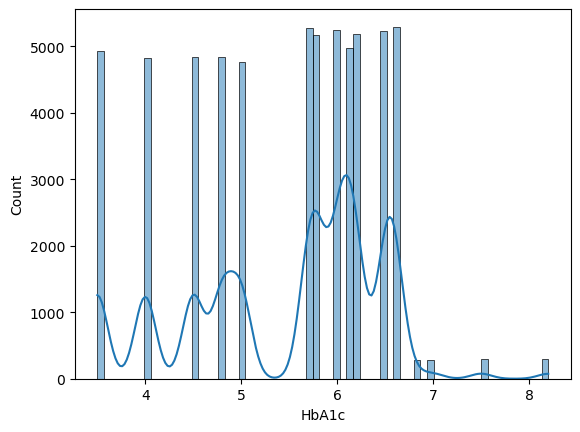

In [43]:
# Distribution plot of 'HbA1c'
sns.histplot(data = data_train,
             x = 'HbA1c',
             kde = True)

In [44]:
# Descriptive of 'HbA1c' by 'diabetes'

data_train['HbA1c'].groupby(data_train['diabetes']).describe()

,count,mean,std,min,25%,50%,75%,max
diabetes,,,,,,,,
0,58490.0,5.395886,0.972353,3.5,4.8,5.8,6.2,6.6
1,3233.0,6.572069,0.727294,5.7,6.0,6.5,7.0,8.2


<AxesSubplot:xlabel='diabetes', ylabel='HbA1c'>

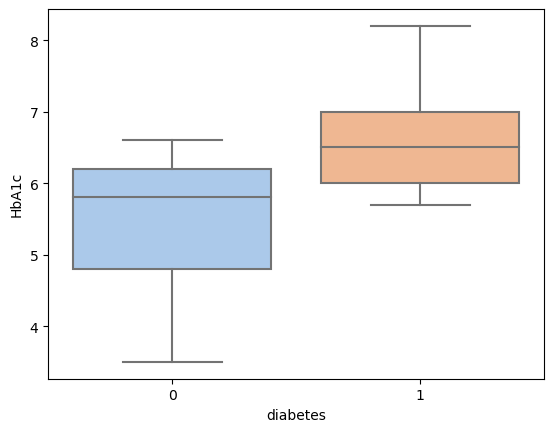

In [45]:
# Boxplot of 'HbA1c' by 'diabetes'

sns.boxplot(data_train['diabetes'], data_train['HbA1c'], palette = 'pastel')

<AxesSubplot:xlabel='HbA1c', ylabel='diabetes'>

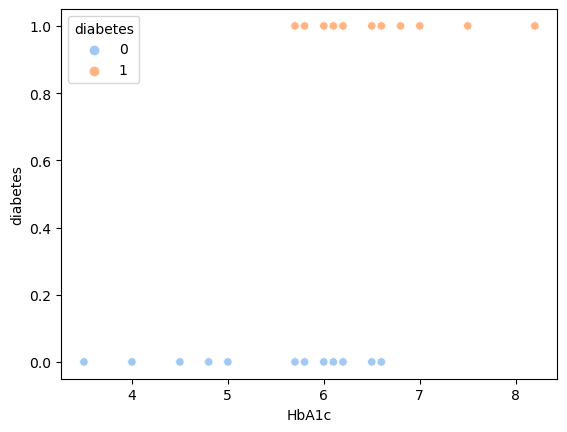

In [46]:
# Check for the perfect separation
sns.scatterplot(data = data_train,
                x = 'HbA1c',
                y = 'diabetes',
                hue = 'diabetes',
                palette = 'pastel')

### 3.8. Predictor 8: 'glucose'

<AxesSubplot:xlabel='glucose', ylabel='Count'>

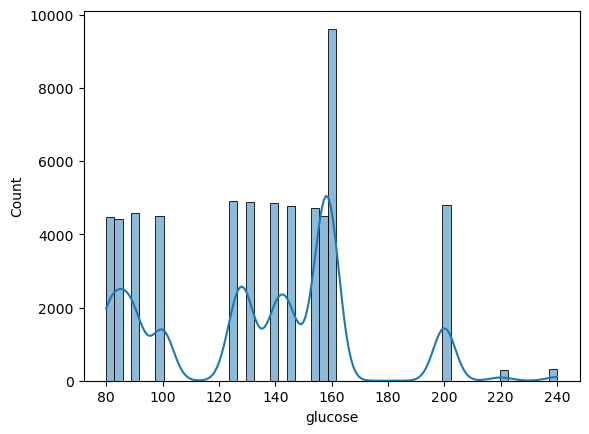

In [47]:
# Distribution plot of 'glucose'
sns.histplot(data = data_train,
             x = 'glucose',
             kde = True)

In [48]:
# Descriptive of 'glucose' by 'diabetes'

data_train['glucose'].groupby(data_train['diabetes']).describe()

,count,mean,std,min,25%,50%,75%,max
diabetes,,,,,,,,
0,58490.0,132.825799,34.254956,80.0,100.0,140.0,158.0,200.0
1,3233.0,167.165481,37.087769,126.0,140.0,159.0,200.0,240.0


<AxesSubplot:xlabel='diabetes', ylabel='glucose'>

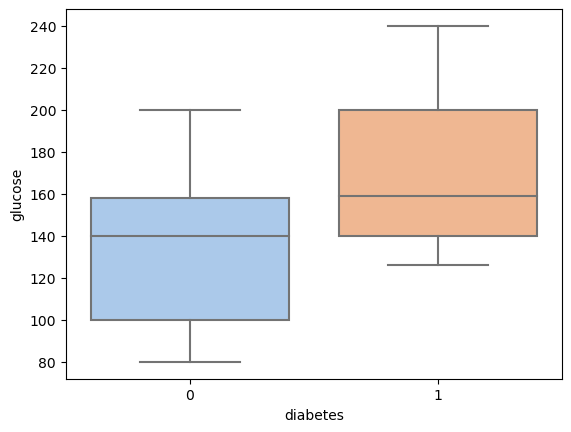

In [49]:
# Boxplot of 'HbA1c' by 'diabetes'

sns.boxplot(data_train['diabetes'], data_train['glucose'], palette = 'pastel')

<AxesSubplot:xlabel='glucose', ylabel='diabetes'>

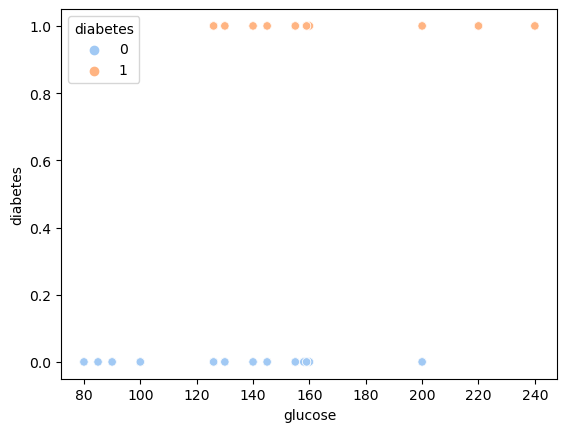

In [50]:
# Check for the perfect separation
sns.scatterplot(data = data_train,
                x = 'glucose',
                y = 'diabetes',
                hue = 'diabetes',
                palette = 'pastel')

## 4. Pre-processing train data

### 4.1. Replace 'No Info' with 'never' in smoking column

In [51]:
# Replace No Info with never
data_train.replace(to_replace = "No Info",
                   value = "never",
                   inplace = True)

data_train['smoking'].value_counts()

never          43585
current         5900
former          5673
not current     4039
ever            2526
Name: smoking, dtype: int64

### 4.2. Create dummies

In [52]:
# Table check

data_train.head()

,gender,age,hypertension,heart_disease,smoking,bmi,HbA1c,glucose,diabetes
10474,Male,27.0,0,0,never,21.23,3.5,145,0
92174,Male,12.0,0,0,never,19.72,4.5,158,0
2351,Female,48.0,0,0,never,27.90,5.8,140,0
82543,Female,61.0,0,0,never,19.47,5.0,160,0
85789,Female,29.0,0,0,never,24.36,6.2,145,0


In [53]:
# Check data type

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61723 entries, 10474 to 43168
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         61723 non-null  object 
 1   age            61723 non-null  float64
 2   hypertension   61723 non-null  int64  
 3   heart_disease  61723 non-null  int64  
 4   smoking        61723 non-null  object 
 5   bmi            61723 non-null  float64
 6   HbA1c          61723 non-null  float64
 7   glucose        61723 non-null  int64  
 8   diabetes       61723 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.7+ MB


There are 4 numerical predictors and 4 categorical predictors:
- Numerical Predictors
  1. `age`
  2. `bmi`
  3. `HbA1c`
  4. `glucose`
- Categorical Predictors
  1. `gender` (multicategory)
  2. `hypertension` (binary)
  3. `heart_disease` (binary)
  4. `smoking` (multicategory)

- Create dummies for some categorical predictors:
  1. `gender` (binary)
  2. `smoking_status` (multicategory)

In [54]:
data_train['smoking'].value_counts()

never          43585
current         5900
former          5673
not current     4039
ever            2526
Name: smoking, dtype: int64

In [55]:
# Create dummy variables for gender (1: Male, 0: Female)
data_train[['Male']] = pd.get_dummies(data_train['gender'],
                                      drop_first = True)

In [56]:
# Create dummy variables for smoking_status (reference: never)
data_train[['current',
            'former',
            'not current',
            'ever']] = pd.get_dummies(data_train['smoking'], drop_first = True)

In [57]:
data_train.keys()

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking', 'bmi',
       'HbA1c', 'glucose', 'diabetes', 'Male', 'current', 'former',
       'not current', 'ever'],
      dtype='object')

In [58]:
# Redefine the training set
data_train = data_train[['age', 'hypertension', 'heart_disease', 'bmi',
                         'HbA1c', 'glucose', 'diabetes', 'Male',
                         'current', 'former', 'not current', 'ever']]

data_train.head()

,age,hypertension,heart_disease,bmi,HbA1c,glucose,diabetes,Male,current,former,not current,ever
10474,27.0,0,0,21.23,3.5,145,0,1,0,0,1,0
92174,12.0,0,0,19.72,4.5,158,0,1,0,0,1,0
2351,48.0,0,0,27.90,5.8,140,0,0,0,0,1,0
82543,61.0,0,0,19.47,5.0,160,0,0,0,0,1,0
85789,29.0,0,0,24.36,6.2,145,0,0,0,0,1,0


### 4.3. Data balancing

<AxesSubplot:xlabel='diabetes', ylabel='count'>

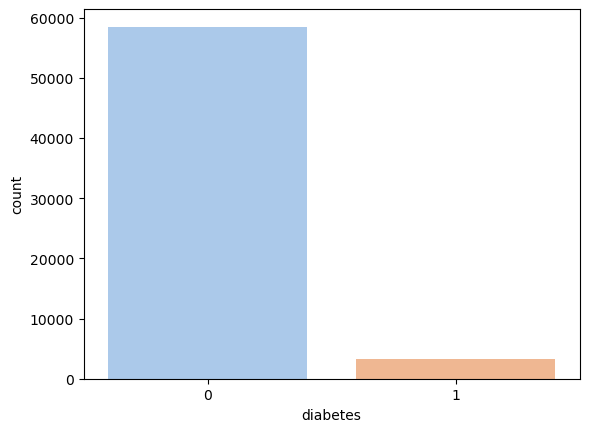

In [59]:
# Response variable distribution plot

sns.countplot('diabetes', data = data_train, palette = 'pastel')

In [60]:
# The counts of response variable

data_train['diabetes'].value_counts()

0    58490
1     3233
Name: diabetes, dtype: int64

In [61]:
!pip install imblearn

**1. Random Oversampling (ROS)**

In [62]:
from imblearn.over_sampling import RandomOverSampler

def ros_fit_resample(data_train: pd.DataFrame, response_variable) -> pd.DataFrame:

    # Create copy of set data
    data_train = data_train.copy()

    # Create sampling object
    ros = RandomOverSampler(random_state = 73)

    # Balancing data set
    x_ros, y_ros = ros.fit_resample(data_train.drop([response_variable], axis = 1),
                                    data_train[response_variable])

    # Concatenate balanced data set
    data_train_ros = pd.concat([x_ros, y_ros], axis = 1)

    # Return balanced data set
    return data_train_ros

In [63]:
# Perform ROS
data_train_ros = ros_fit_resample(data_train = data_train,
                                  response_variable = response_variable)

<AxesSubplot:xlabel='diabetes', ylabel='count'>

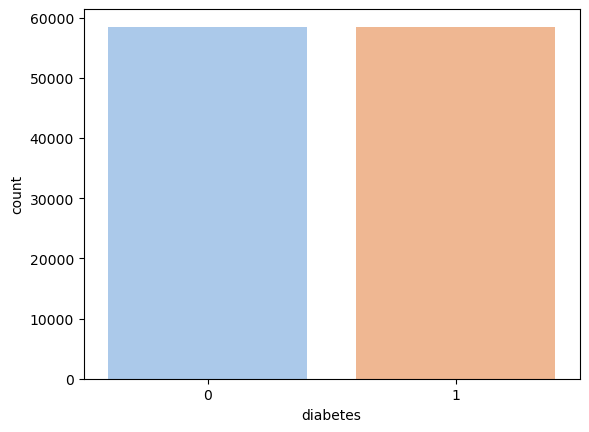

In [64]:
# Check the proportion of response variable

sns.countplot('diabetes', data = data_train_ros, palette = 'pastel')

In [65]:
# Check the balanced response variable

data_train_ros['diabetes'].value_counts()

0    58490
1    58490
Name: diabetes, dtype: int64

**2. Random Undersampling (RUS)**

In [66]:
from imblearn.under_sampling import RandomUnderSampler

def rus_fit_resample(data_train: pd.DataFrame, response_variable) -> pd.DataFrame:

    # Create copy of set data
    data_train = data_train.copy()

    # Create sampling object
    rus = RandomUnderSampler(random_state = 73)

    # Balancing data set
    x_rus, y_rus = rus.fit_resample(data_train.drop([response_variable], axis = 1),
                                    data_train[response_variable])

    # Concatenate balanced data set
    data_train_rus = pd.concat([x_rus, y_rus], axis = 1)

    # Return balanced data set
    return data_train_rus

In [67]:
# Perform RUS
data_train_rus = rus_fit_resample(data_train = data_train,
                                  response_variable = response_variable)

<AxesSubplot:xlabel='diabetes', ylabel='count'>

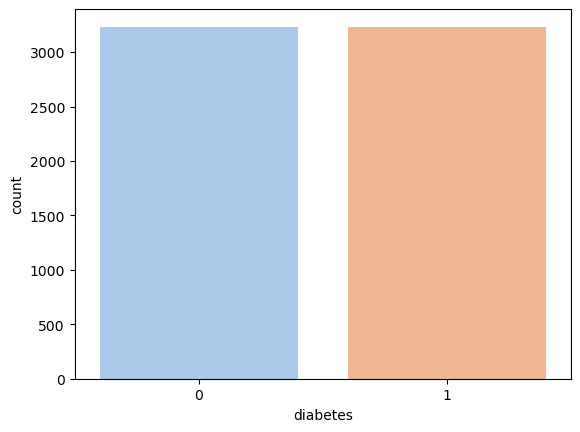

In [68]:
# Check the proportion of response variable

sns.countplot('diabetes', data = data_train_rus, palette = 'pastel')

In [69]:
# Check the balanced response variable

data_train_rus['diabetes'].value_counts()

0    3233
1    3233
Name: diabetes, dtype: int64

## **5. Pre-processing Testing Set**

First, we process the test data according to the pre-processing pipeline in train data.

In [70]:
# Concatenate X_test and y_test as data_test
data_test = pd.concat((X_test, y_test), axis=1)

# Validate data_test
print('Test data shape:', data_test.shape)

Test data shape: (26459, 9)


In [71]:
# Table check
data_test.head()

,gender,age,hypertension,heart_disease,smoking,bmi,HbA1c,glucose,diabetes
93469,Female,56.00,0,0,current,27.32,5.7,100,0
95060,Female,17.00,0,0,No Info,20.93,3.5,80,0
31969,Female,7.00,0,0,No Info,27.32,5.0,80,0
59005,Female,1.88,0,0,No Info,16.68,4.0,80,0
72672,Female,55.00,0,0,current,26.85,6.5,85,0


###### 1. Drop gender 'Other'.

In [72]:
# Describe proportion of 'gender'

data_test['gender'].value_counts()

Female    15353
Male      11101
Other         5
Name: gender, dtype: int64

In [73]:
# Drop 'Other' from 'gender'
data_test.drop(data_test[(data_test['gender'] == 'Other')].index,
               inplace = True)

In [74]:
data_test.shape

(26454, 9)

###### 2. Replace 'No Info' with 'never' in smoking column

In [75]:
# Replace No Info with never
data_test.replace(to_replace = "No Info",
                   value = "never",
                   inplace = True)

data_test['smoking'].value_counts()

never          18766
former          2460
current         2449
not current     1717
ever            1062
Name: smoking, dtype: int64

###### 3. Create dummies

- Create dummies for some categorical predictors:
  1. `gender` (binary)
  2. `smoking_status` (multicategory)

In [76]:
# Create dummy variables for gender (1: Male, 0: Female)
data_test[['Male']] = pd.get_dummies(data_test['gender'],
                                      drop_first = True)

In [77]:
# Create dummy variables for smoking_status (reference: never)
data_test[['current',
            'former',
            'not current',
            'ever']] = pd.get_dummies(data_test['smoking'], drop_first = True)

In [78]:
data_test.keys()

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking', 'bmi',
       'HbA1c', 'glucose', 'diabetes', 'Male', 'current', 'former',
       'not current', 'ever'],
      dtype='object')

In [79]:
# Redefine the training set
data_test = data_test[['age', 'hypertension', 'heart_disease', 'bmi',
                       'HbA1c', 'glucose', 'diabetes', 'Male',
                       'current', 'former', 'not current', 'ever']]

data_test.head()

,age,hypertension,heart_disease,bmi,HbA1c,glucose,diabetes,Male,current,former,not current,ever
93469,56.00,0,0,27.32,5.7,100,0,0,0,0,0,0
95060,17.00,0,0,20.93,3.5,80,0,0,0,0,1,0
31969,7.00,0,0,27.32,5.0,80,0,0,0,0,1,0
59005,1.88,0,0,16.68,4.0,80,0,0,0,0,1,0
72672,55.00,0,0,26.85,6.5,85,0,0,0,0,0,0


In [80]:
# Split response and predictors
X_test = data_test.drop(columns=[response_variable], axis=1)
y_test = data_test[response_variable]

# Convert dataframe to numpy
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Validate the splitting
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_test shape : (26454, 11)
y_test shape : (26454,)


## 6. Model Selection

### Load Functions for Model Selection

- AIC, KFold, and Forward Selection

In [81]:
def AIC(y_true, y_pred, p):
    """
    Parameters
    ----------
    y_true : {array-like} of shape (n_sample, )
        Actual value of response variable.

    y_pred : {array-like} of shape (n_sample, 1)
        The success probability of X.

    p : int
        Number of parameters in model.

    Returns
    -------
    aic : float
        AIC value.
    """
    # Find the average log likelihood value
    llf = np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    # AIC value is sensitive to number of parameters
    # The average log likelihood represent value for 1 unit observation
    # AIC from average llf is not comparable
    # Multiply llf by n_sample=173 to make its AIC comparable
    llf *= data_train.shape[0]

    # Calculate AIC
    aic = -2 * (llf - p)

    return aic


In [82]:
def kfold_split(X, k = 5, random_state = 73):
    """
    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        All predictors set.

    k : int,
        Number of folds.

    random_state : int
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    train_ind_list : list
        Contains data index of train set.

    valid_ind_list : list
        Contains data index of validation set.
    """
    # Extract sample size
    n_samples, _ = X.shape

    # Set random state
    np.random.seed(random_state)

    # # Randomize index
    random_ind = np.random.choice(n_samples,
                                  size = n_samples,
                                  replace = False)

    # Calculate size of each fold
    fold_sizes = np.ones(k, dtype=int) * (n_samples//k)
    fold_sizes[:n_samples%k] += 1

    # Define initial list for each train and valid index
    train_ind_list = []
    valid_ind_list = []

    # Split sample
    current_ind = 0
    for size in fold_sizes:
        # Define index
        start_ind = current_ind
        end_ind = current_ind + size

        # Slice valid set
        # One fold for valid set, the remaining for train set
        valid_ind = random_ind[start_ind:end_ind]
        train_ind = np.concatenate((random_ind[:start_ind],
                                    random_ind[end_ind:]))

        # Update current index
        current_ind = end_ind

        # Append train and valid index in list
        train_ind_list.append(train_ind)
        valid_ind_list.append(valid_ind)

    return train_ind_list, valid_ind_list


In [83]:
def cross_validate(X, y, method, cv, random_state = 73):
    """
    Function to evaluate AIC by cross-validation method.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        The independent variable or predictors.

    y : {array-like} of shape (n_sample, )
        The dependent or response variable.

    method : cross-validation splitter
        Cross-validation method.

    cv : int
        Number of folds for k-Fold CV.

    random_state : int
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    score : float
        The average AIC score.
    """
    # Split train and valid set based on CV method
    if method == "validation_set":
        train_ind_list, valid_ind_list = validation_set_split(X = X,
                                                              random_state = random_state)
    elif method == "loocv":
        train_ind_list, valid_ind_list = loocv_split(X = X)
    elif method == "kfold":
        train_ind_list, valid_ind_list = kfold_split(X = X,
                                                     k = cv,
                                                     random_state = random_state)

    # Define the number of train sets
    n_split = len(train_ind_list)

    # Initialize AIC score list for each valid set
    score_list = []

    for i in range(n_split):
        # Extract data from index
        X_train = X[train_ind_list[i]]
        y_train = y[train_ind_list[i]]
        X_valid = X[valid_ind_list[i]]
        y_valid = y[valid_ind_list[i]]

        # Add constant
        X_train = sm.add_constant(X_train, has_constant="add")
        X_valid = sm.add_constant(X_valid, has_constant="add")

        # Fitting model
        model = sm.Logit(y_train, X_train)
        results = model.fit(disp=False)

        # Calculate success probability
        y_pred_train = results.predict(X_train)
        y_pred_valid = results.predict(X_valid)

        # Calculate AIC
        aic_train = AIC(y_true = y_train,
                        y_pred = y_pred_train,
                        p = X_train.shape[1])
        aic_valid = AIC(y_true = y_valid,
                        y_pred = y_pred_valid,
                        p = X_train.shape[1])

        # Append AIC score in list
        score_list.append(aic_valid)

    # Calculate CV Score
    score = np.mean(score_list)

    return score


In [84]:
def forward(X, y, predictors, method, cv = 5, random_state = 73):
    """
    Function to perform best subset selection procedure.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        All predictors set.

    y : {array-like} of shape (n_sample, )
        The dependent or response variable.

    predictors : {array-like} of shape (n_sample, )
        Index of predictors

    method : cross-validation splitter
        Cross-validation method.

    cv : int, default=5
        Number of folds for k-Fold CV.

    random_state : int, default=42
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    models : {array-like} of shape (n_combinations, k)
        Summary of predictors and its AIC score for each possible combination.

    best_model : {array-like} of shape (2, )
        Best model of models with the smallest AIC score.
    """

    # Initialize list of results
    results = []

    # Define sample size and  number of all predictors
    n_samples, n_predictors = X.shape

    # Define list of all predictors
    col_list = np.arange(n_predictors)

    # Define remaining predictors for each k
    remaining_predictors = [p for p in col_list if p not in predictors]

    # Initialize list of predictors and its CV Score
    pred_list = []
    score_list = []

    # Cross validate each possible combination of remaining predictors
    for p in remaining_predictors:
        combi = predictors + [p]

        # Extract predictors combination
        X_ = X[:, combi]
        y_ = y

        # Cross validate to get CV Score
        score_ = cross_validate(X = X_,
                                y = y_,
                                method = method,
                                cv = cv,
                                random_state = random_state)

        # Append predictors combination and its CV Score to the list
        pred_list.append(list(combi))
        score_list.append(score_)

    # Tabulate the results
    models = pd.DataFrame({"Predictors": pred_list,
                            "AIC": score_list})

    # Choose the best model
    best_model = models.loc[models["AIC"].argmin()]

    return models, best_model


### **1. Original training set**

In [85]:
# Split response and predictors
X_train = data_train.drop(columns = [response_variable], axis=1)
y_train = data_train[response_variable]

# Convert dataframe to numpy
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# Validate
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (61723, 11)
y_train shape: (61723,)


Fit the null (constant) model.

In [86]:
# Fit null model
predictor = []
score_ = cross_validate(X = X_train[:, [1]],
                        y = y_train,
                        method = 'kfold',
                        cv = 5,
                        random_state = 73)

# Create table for the best model of each k predictors
# Append the results of null model
forward_models = pd.DataFrame({"Predictors": [predictor],
                               "AIC": [score_]})

forward_models

,Predictors,AIC
0,[],24326.445897


Perform the forward selection procedure.

In [87]:
# Define list of predictors
predictors = []
n_predictors = X_train.shape[1]

# Perform forward selection procedure for k=1,...,13 predictors
for k in range(n_predictors):
    _, best_model = forward(X = X_train,
                            y = y_train,
                            predictors = predictors,
                            method = "kfold",
                            cv = 5,
                            random_state = 73)

    # Tabulate the best model of each k predictors
    forward_models.loc[k+1] = best_model
    predictors = best_model["Predictors"]

In [88]:
# Print the best model of each k predictors
forward_models

,Predictors,AIC
0,[],24326.445897
1,[4],19098.679516
2,"[4, 0]",16461.858108
3,"[4, 0, 5]",14439.163359
4,"[4, 0, 5, 3]",13936.646311
5,"[4, 0, 5, 3, 1]",13781.823321
6,"[4, 0, 5, 3, 1, 2]",13686.245438
7,"[4, 0, 5, 3, 1, 2, 6]",13654.287176
8,"[4, 0, 5, 3, 1, 2, 6, 9]",13632.283813
9,"[4, 0, 5, 3, 1, 2, 6, 9, 10]",13634.995883


Next, find the best model with the smallest AIC score.

In [89]:
# Find the best AIC score
best_idx = forward_models['AIC'].argmin()
best_AIC = forward_models['AIC'].loc[best_idx]
best_predictors = forward_models['Predictors'].loc[best_idx]

# print
print('Best index            :', best_idx)
print('Best AIC              :', best_AIC)
print('Best predictors (idx) :', best_predictors)
print('Best predictors       :')
print(data_train.columns[best_predictors].tolist())

Best index            : 8
Best AIC              : 13632.283813116384
Best predictors (idx) : [4, 0, 5, 3, 1, 2, 6, 9]
Best predictors       :
['HbA1c', 'age', 'glucose', 'bmi', 'hypertension', 'heart_disease', 'diabetes', 'former']


**Refit** the best model on whole `X_train` data.

In [90]:
# Define X with best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
best_model_ori = LogisticRegression(penalty = 'none',
                                    class_weight = None)
best_model_ori.fit(X_train_best, y_train)

LogisticRegression(penalty='none')

### **2. ROS training set**

In [91]:
# Split response and predictors
X_train_ros = data_train_ros.drop(columns = [response_variable], axis=1)
y_train_ros = data_train_ros[response_variable]

# Convert dataframe to numpy
X_train_ros = X_train_ros.to_numpy()
y_train_ros = y_train_ros.to_numpy()

# Validate the splitting
print('X_train_ros shape :', X_train_ros.shape)
print('y_train_ros shape :', y_train_ros.shape)

X_train_ros shape : (116980, 11)
y_train_ros shape : (116980,)


Fit the null (constant) model.

In [92]:
# Fit null model
predictor = []
score_ = cross_validate(X = X_train_ros[:, [1]],
                        y = y_train_ros,
                        method = 'kfold',
                        cv = 5,
                        random_state = 73)

# Create table for the best model of each k predictors
# Append the results of null model
forward_models_ros = pd.DataFrame({"Predictors": [predictor],
                                   "AIC": [score_]})

forward_models_ros

,Predictors,AIC
0,[],81292.708795


Perform the forward selection procedure.

In [93]:
# Define list of predictors
predictors = []
n_predictors = X_train_ros.shape[1]

# Perform forward selection procedure for k=1,...,13 predictors
for k in range(n_predictors):
    _, best_model = forward(X = X_train_ros,
                            y = y_train_ros,
                            predictors = predictors,
                            method = "kfold",
                            cv = 5,
                            random_state = 73)

    # Tabulate the best model of each k predictors
    forward_models_ros.loc[k+1] = best_model
    predictors = best_model["Predictors"]

In [94]:
# Print the best model of each k predictors
forward_models_ros

,Predictors,AIC
0,[],81292.708795
1,[4],59988.146245
2,"[4, 0]",47521.750799
3,"[4, 0, 5]",40706.256556
4,"[4, 0, 5, 3]",39044.764125
5,"[4, 0, 5, 3, 1]",38530.816188
6,"[4, 0, 5, 3, 1, 2]",38284.518605
7,"[4, 0, 5, 3, 1, 2, 6]",38132.274155
8,"[4, 0, 5, 3, 1, 2, 6, 9]",38052.219861
9,"[4, 0, 5, 3, 1, 2, 6, 9, 10]",38050.269964


Next, find the best model with the smallest AIC score.

In [95]:
# Find the best AIC score
best_idx_ros = forward_models_ros['AIC'].argmin()
best_AIC_ros = forward_models_ros['AIC'].loc[best_idx_ros]
best_predictors_ros = forward_models_ros['Predictors'].loc[best_idx_ros]

# print
print('Best index            :', best_idx_ros)
print('Best AIC              :', best_AIC_ros)
print('Best predictors (idx) :', best_predictors_ros)
print('Best predictors       :')
print(data_train_ros.columns[best_predictors_ros].tolist())

Best index            : 9
Best AIC              : 38050.269963777675
Best predictors (idx) : [4, 0, 5, 3, 1, 2, 6, 9, 10]
Best predictors       :
['HbA1c', 'age', 'glucose', 'bmi', 'hypertension', 'heart_disease', 'Male', 'not current', 'ever']


**Refit** the best model on whole `X_train_ros` data.

In [96]:
# Define X with best predictors
X_train_best_ros = X_train_ros[:, best_predictors_ros]

# Fit best model
best_ros_model = LogisticRegression(penalty = 'none',
                                    class_weight = None)
best_ros_model.fit(X_train_best_ros, y_train_ros)

LogisticRegression(penalty='none')

### **3. RUS training set**

In [97]:
# Split response and predictors
X_train_rus = data_train_rus.drop(columns = [response_variable], axis=1)
y_train_rus = data_train_rus[response_variable]

# Convert dataframe to numpy
X_train_rus = X_train_rus.to_numpy()
y_train_rus = y_train_rus.to_numpy()

# Validate the splitting
print('X_train_rus shape :', X_train_rus.shape)
print('y_train_rus shape :', y_train_rus.shape)

X_train_rus shape : (6466, 11)
y_train_rus shape : (6466,)


Fit the null (constant) model.

In [98]:
# Fit null model
predictor = []
score_ = cross_validate(X = X_train_rus[:, [1]],
                        y = y_train_rus,
                        method = 'kfold',
                        cv = 5,
                        random_state = 73)

# Create table for the best model of each k predictors
# Append the results of null model
forward_models_rus = pd.DataFrame({"Predictors": [predictor],
                                   "AIC": [score_]})

forward_models_rus

,Predictors,AIC
0,[],81337.457533


Perform the forward selection procedure.

In [99]:
# Define list of predictors
predictors = []
n_predictors = X_train_rus.shape[1]

# Perform forward selection procedure for k=1,...,13 predictors
for k in range(n_predictors):
    _, best_model = forward(X = X_train_rus,
                            y = y_train_rus,
                            predictors = predictors,
                            method = "kfold",
                            cv = 5,
                            random_state = 73)

    # Tabulate the best model of each k predictors
    forward_models_rus.loc[k+1] = best_model
    predictors = best_model["Predictors"]

In [100]:
# Print the best model of each k predictors
forward_models_rus

,Predictors,AIC
0,[],81337.457533
1,[4],59886.272437
2,"[4, 0]",46992.976089
3,"[4, 0, 5]",40315.816117
4,"[4, 0, 5, 3]",38961.085437
5,"[4, 0, 5, 3, 1]",38573.873197
6,"[4, 0, 5, 3, 1, 6]",38361.782267
7,"[4, 0, 5, 3, 1, 6, 2]",38219.347503
8,"[4, 0, 5, 3, 1, 6, 2, 8]",38218.521298
9,"[4, 0, 5, 3, 1, 6, 2, 8, 10]",38219.207526


Next, find the best model with the smallest AIC score.

In [101]:
# Find the best AIC score
best_idx_rus = forward_models_rus['AIC'].argmin()
best_AIC_rus = forward_models_rus['AIC'].loc[best_idx_rus]
best_predictors_rus = forward_models_rus['Predictors'].loc[best_idx_rus]

# print
print('Best index            :', best_idx_rus)
print('Best AIC              :', best_AIC_rus)
print('Best predictors (idx) :', best_predictors_rus)
print('Best predictors       :')
print(data_train_rus.columns[best_predictors_rus].tolist())

Best index            : 8
Best AIC              : 38218.5212984929
Best predictors (idx) : [4, 0, 5, 3, 1, 6, 2, 8]
Best predictors       :
['HbA1c', 'age', 'glucose', 'bmi', 'hypertension', 'Male', 'heart_disease', 'former']


**Refit** the best model on whole `X_train_rus` data.

In [102]:
# Define X with best predictors
X_train_best_rus = X_train_rus[:, best_predictors_rus]

# Fit best model
best_rus_model = LogisticRegression(penalty = 'none',
                                    class_weight = None)
best_rus_model.fit(X_train_best_rus, y_train_rus)

LogisticRegression(penalty='none')

## **7. Model Evaluation**

3 best models from each method of preprocessing:
1. Original training set
2. ROS training set
3. RUS training set

Compare the best models' performance by its
- AIC on training set
- AIC on testing set
- AUC score

First, create a function to return those metrics.

In [103]:
import sklearn.metrics as metrics

def predict_test(X_test, y_test, model, predictors):
    # Calculate success probability
    X_test_best = X_test[:, predictors]
    pred_test = model.predict_proba(X_test_best)
    y_pred_test = pred_test[:,1]
    
    # Calculate AIC
    aic_test = AIC(y_true = y_test,
                   y_pred = y_pred_test,
                   p = X_test.shape[1]+1)
    
    # Calculate AUC
    auc = metrics.roc_auc_score(y_true = y_test,
                              y_score = y_pred_test)
    
    return y_pred_test, round(aic_test, 2), round(auc, 2)

### **1. Original training set**

In [104]:
y_pred_test, aic_test, auc = predict_test(X_test = X_test,
                                          y_test = y_test,
                                          model = best_model_ori,
                                          predictors = best_predictors)

y_pred_test, aic_test, auc

(array([4.98925512e-03, 2.45454304e-06, 7.16633077e-05, ...,
        1.56713337e-05, 2.11347492e-04, 3.64529273e-03]),
 14841.1,
 0.93)

In [105]:
# Summarize in a table
model_eval = pd.Series({'Method': 'Original',
                        'Predictors' : best_predictors,
                        'AIC Train': best_AIC,
                        'AIC Test' : aic_test,
                        'AUC' : auc})

model_eval = model_eval.to_frame()
model_eval.T

,Method,Predictors,AIC Train,AIC Test,AUC
0,Original,"[4, 0, 5, 3, 1, 2, 6, 9]",13632.283813,14841.1,0.93


<AxesSubplot:ylabel='Count'>

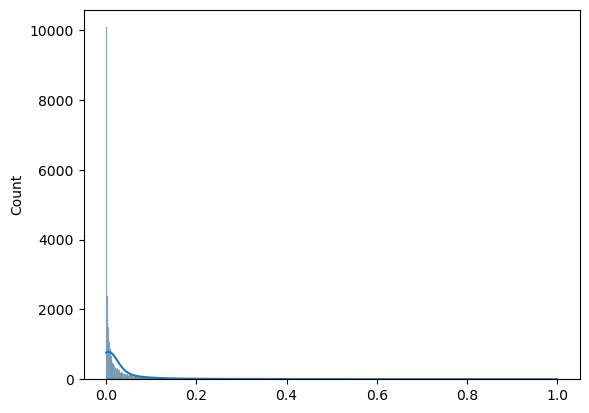

In [106]:
# Distribution plot of predicted probability
sns.histplot(x = y_pred_test,
             kde = True)

### **2. ROS training set**

In [107]:
y_pred_test_ros, aic_test_ros, auc_ros = predict_test(X_test = X_test,
                                                      y_test = y_test,
                                                      model = best_ros_model,
                                                      predictors = best_predictors_ros)
y_pred_test_ros, aic_test_ros, auc_ros

(array([9.03146060e-02, 1.37456918e-05, 3.96926564e-04, ...,
        1.29891915e-04, 2.21582577e-03, 7.39909918e-02]),
 44074.81,
 0.93)

In [108]:
# Summarize the ROS model performance
ros_eval = pd.Series({'Method': 'Oversampling',
                      'Predictors' : best_predictors_ros,
                      'AIC Train': best_AIC_ros,
                      'AIC Test' : aic_test_ros,
                      'AUC' : auc_ros})

# Concatenate to model_eval summary
model_eval = pd.concat([model_eval, ros_eval],
                       axis=1,
                       ignore_index=True)
model_eval.T

,Method,Predictors,AIC Train,AIC Test,AUC
0,Original,"[4, 0, 5, 3, 1, 2, 6, 9]",13632.283813,14841.1,0.93
1,Oversampling,"[4, 0, 5, 3, 1, 2, 6, 9, 10]",38050.269964,44074.81,0.93


<AxesSubplot:ylabel='Count'>

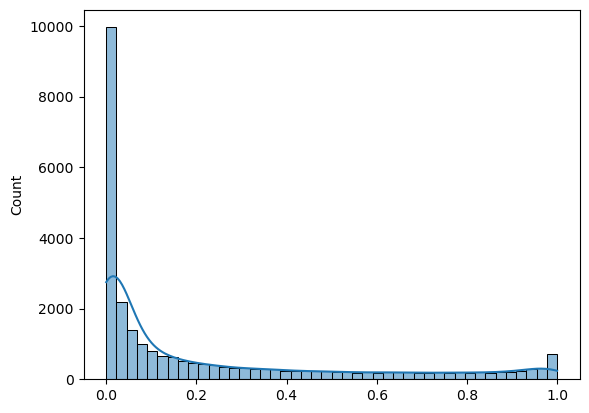

In [109]:
# Distribution plot of predicted probability
sns.histplot(x = y_pred_test_ros,
             kde = True)

### **3. RUS training set**

In [110]:
y_pred_test_rus, aic_test_rus, auc_rus = predict_test(X_test = X_test,
                                                      y_test = y_test,
                                                      model = best_rus_model,
                                                      predictors = best_predictors_rus)

y_pred_test_rus, aic_test_rus, auc_rus

(array([7.72093683e-02, 3.98732855e-05, 9.53712315e-04, ...,
        3.28446938e-04, 2.85211640e-03, 5.20814001e-02]),
 41783.13,
 0.94)

In [111]:
# Summarize the RUS model performance
rus_eval = pd.Series({'Method': 'Undersampling',
                      'Predictors' : best_predictors_rus,
                      'AIC Train': best_AIC_rus,
                      'AIC Test' : aic_test_rus,
                      'AUC' : auc_rus})

# Concatenate to model_eval summary
model_eval = pd.concat([model_eval, rus_eval],
                       axis=1,
                       ignore_index=True)
model_eval.T

,Method,Predictors,AIC Train,AIC Test,AUC
0,Original,"[4, 0, 5, 3, 1, 2, 6, 9]",13632.283813,14841.1,0.93
1,Oversampling,"[4, 0, 5, 3, 1, 2, 6, 9, 10]",38050.269964,44074.81,0.93
2,Undersampling,"[4, 0, 5, 3, 1, 6, 2, 8]",38218.521298,41783.13,0.94


<AxesSubplot:ylabel='Count'>

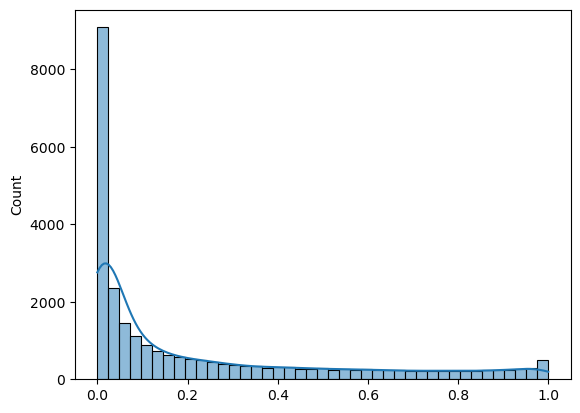

In [112]:
# Distribution plot of predicted probability
sns.histplot(x = y_pred_test_rus,
             kde = True)

### Evaluate the predictions

In [127]:
def predictive_performance(model_result, X_test, y_test, threshold = 0.5):
    """
    Calculate model's predictive performance

    Parameters
    ----------
    model_result : result of fitted model
        Model result from Statsmodels Logit

    threshold : float in range[0,1], default = 0.5
        Cut-off probability to classify predicted outcome

    Returns
    -------
    accuracy : float
        The accuracy

    sensitivity : float
        The true positive rate

    specificity : float
        The true negative rate
    """

    X_test_sm = sm.add_constant(X_test)
    predict_proba = y_pred_test_rus

    # Define output y=1 or y=0
    output_list=[]
    for i in predict_proba:
        if i > threshold:
            output_list.append(1)
        else:
            output_list.append(0)

    y_pred = np.array(output_list)

    # Calculate the confusion matrix
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if y_pred[i]==1 and y_test[i]==1:
            TP += 1
        elif y_pred[i]==1 and y_test[i]==0:
            FP += 1
        elif y_pred[i]==0 and y_test[i]==1:
            FN += 1
        else:
            TN += 1

    # Calculate metrics from classification matric
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    sensitivity = (TP)/(TP+FN)
    specificity = (TN)/(TN+FP)

    return accuracy, sensitivity, specificity


In [128]:
# Calculate the best model's predictive performance on test set
# Set the decision threshold = 0.5
accuracy, sensitivity, specificity = predictive_performance(model_result = best_rus_model,
                                                            X_test = X_test[:, best_predictors_rus],
                                                            y_test = y_test,
                                                            threshold = 0.5)

accuracy, sensitivity, specificity

(0.8442579572087398, 0.8671480144404332, 0.8429933383860545)

Plot ROC and calculate AUC.

In [124]:
# Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
fpr, tpr, threshold = metrics.roc_curve(y_true = y_test,
                                        y_score = y_pred_test_rus)

# Calculate AUC score using method sklearn.metrics.roc_auc_score
auc = metrics.roc_auc_score(y_true = y_test,
                            y_score = y_pred_test_rus)

auc = round(auc, 2)

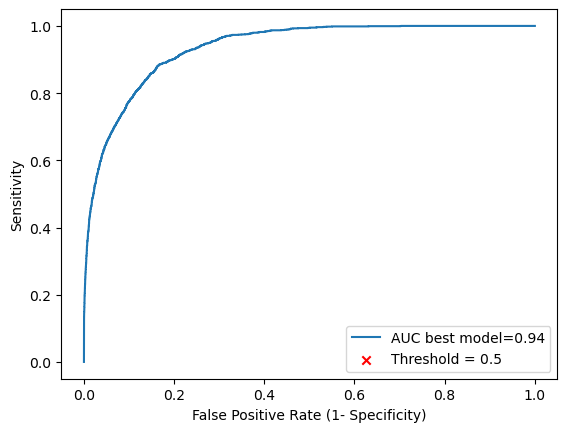

In [125]:
# Plot ROC and its AUC
plt.plot(fpr,
         tpr,
         label = "AUC best model="+str(auc))

plt.scatter(fpr[(threshold > 0.5) & (threshold < 0.50005)],
            tpr[(threshold > 0.5) & (threshold < 0.50005)],
            label = 'Threshold = 0.5',
            marker = 'x',
            color = 'r')

plt.ylabel("Sensitivity")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.legend(loc = 4)
plt.show()

Summary from ROC:
- If we choose `threshold = 0.5`, we will get:
  - False Positive Rate = 0.16
  - True Positive Rate (Sensitivity) = 0.86

- That means:
  - There is a probability of 16% to incorrectly predict the actual diabetes patient.
      - Note that we have a trade-off of a higher false positive rate when aiming for higher sensitivity.

### Interpret the Best Model Parameters

In [129]:
best_model_params = ['constant'] + X_test[:, best_predictors_rus].tolist()
best_model_summary = pd.DataFrame({
                                    'weights': best_rus_model.params,
                                    'OR': np.exp(best_rus_model.params)
                                  },
                                  index = best_model_params)

best_model_summary

AttributeError: 'LogisticRegression' object has no attribute 'params'